## "Active Sciencing" with Reusable Workflows

By Kyle Cranmer & Lukas Heinrich June 4, 2016

Based on earlier work with NYU CDS masters students Manoj Kumar, Phil Yeres, and Michele Ceru and discussions with Brenden Lake and Gilles Louppe.

Define:

 1) $\phi$ : Experimental configuration

 2) $\theta$: Parameters that we would like to infer from the experimental data

 3) $X$ : Data generated from the experiment or simulator



In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import emcee
from scipy.stats import norm

from prior_dist import Distribution

## Step 1: Perform Experiment, Collect Data

In [3]:
def simulator(theta, phi, n_samples=100):
    return np.random.normal(loc=theta, scale=2 + np.sin(phi), size=n_samples)

def collect_data(phi, n_samples=100):
    # 3.141 is the unknown parameter we are trying to measure
    # best experimental setting is 3pi/2 (or any multiple of it)
    return simulator(3.141, phi, n_samples)

## Step 2: Bayesian Prior → Posterior Update 

In [4]:
def lnprior(theta, prior):
    p = prior.pdf(theta)
    if p <= 1e-8:
        return -np.inf
    else:
        return np.log(p)

def lnlike(theta, x, phi):
    #exact likelihood for testing
    #mean, std = theta, 2 + np.sin(phi)
    #return np.log(norm(mean, std).pdf(x).prod())
    
    #approx likelihood
    simdata = simulator(theta, phi,n_samples=1000)
    # this xrange is specific to this simulator
    # better to have auto-range, but would need density to correct for range & bin width
    xrange = (3-9,3+9) 
    approx_density = Distribution(name='approx density', range=xrange,samples=simdata)
    return np.sum(np.log(approx_density.pdf(x)))

def lnprob(theta, x, prior, phi):
    lp = lnprior(theta, prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, phi)

def calculate_posterior(prior, data, phi):
    """Compute samples from the posterior"""
    ndim, n_walkers = 1, 10
    # initialise walkers from the MAP + noise
    # XXX alternatively sample a point from the KDE without adding noise?
    # XXX not sure if the noise takes us into a region where the prior is zero?
    pos = [prior.map() + 1e-1*np.random.randn(ndim) for i in range(n_walkers)]
    
    sampler = emcee.EnsembleSampler(n_walkers, 1, lnprob, args=(data, prior, phi))
    pos, prob, state = sampler.run_mcmc(pos, 100)
    
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 300)
    
    return Distribution(prior.name, prior.range, sampler.flatchain)

## Step 3: Optimize Experimental Configuration

Based on the updated posterior $p(\theta)$ we will consider future experiments with configuration $\phi$. For each of those configurations, we will run several simulations of the experiment and perform inference on those simulated datasets to estimate the expected information gain (EIG)

\begin{equation}
EIG(\phi) =  \int dx d\theta \; p(x | \theta) p(\theta) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ] \approx \int dx  \; p(x | \theta_{MAP}) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ]
\end{equation}
where
\begin{equation}
H\left [P(\theta) \right] = \int P(\theta) \log P(\theta) d\theta 
\end{equation}

To efficiently optimize $EIG[\phi]$ we will use an active learning procedure like Bayesian Optimization.

In [23]:
from multiprocessing import Pool


def info_gain(p1, p2):
    return p1.entropy() - p2.entropy()

def _simulate(args):
    theta_map, phi, prior = args
    # external workflow provides simulated data
    sim_data = simulator(theta_map, phi)

    #external workflow uses simulator to provide likelihood 
    sim_posterior = calculate_posterior(prior, sim_data, phi)
    return info_gain(prior, sim_posterior)


def expected_information_gain(phi, prior):
    'calculate the expression above using workflow for simulations'
    n_simulations = 2
    
    #need to pass in prior through some extra arguments
    
    # use saddle-point approximation
    theta_map = prior.map()

    # currently the MCMC sampler is the slower part, which already uses threads so we don't gain
    # this should change once we have a more realistic simulator that takes time to run
    pool = Pool(4)
    eig = pool.map(_simulate, [(theta_map, phi, prior) for i in range(n_simulations)])

    return np.mean(eig)

In [16]:
#use scikit-optimize to optimize phi
from skopt import gp_minimize


def design_next_experiment(prior):
    bounds = [(0., 2*np.pi)]
    n_calls = 10
    
    func = lambda p: -expected_information_gain(p, prior)

    # five random points to initialise things, then five using the GP model
    # XXX Should we be reusing the random number generator? Means this call eseentially evaluates
    # XXX the same values of phi each science iteration
    opt_result = gp_minimize(func, bounds, n_random_starts=5, n_calls=n_calls, random_state=4)

    return opt_result.x[0], opt_result.x_iters

## Run the loop

### Initialize

In [13]:
tempdata = np.random.uniform(0., 2*np.pi, 100000)
prior_theta = Distribution('p(theta)', range=(0., 2*np.pi), samples=tempdata)

n_science_iterations = 2
phi_history = []
prior_history = []

phi = 1.2345

In [25]:
for i_experiment in range(n_science_iterations):
    print("Experimental settings ({}):".format(i_experiment), phi)
    
    phi_history.append(phi)
    prior_history.append(prior_theta)

    # run experiment with configuration given by phi
    real_data = collect_data(phi)

    # update new prior = posterior from previous experiment
    prior_theta = calculate_posterior(prior_theta, real_data, phi)

    #design new experiment given current knowledge
    phi, phi_iter = design_next_experiment(prior_theta)
    
    print('next phi:', phi, "phi's tested in gp_min:", phi_iter)

Experimental settings (0): 1.2345
next phi: 4.88034059017 phi's tested in gp_min: [[6.0760276760949745], [3.4383616276357372], [6.1115560790547416], [4.4913213487917449], [4.3839594991052548], [4.8803405901736063], [4.8059810967703172], [0.0], [5.0384304516982636], [1.7384347274364642]]
Experimental settings (1): 4.88034059017
next phi: 4.38395949911 phi's tested in gp_min: [[6.0760276760949745], [3.4383616276357372], [6.1115560790547416], [4.4913213487917449], [4.3839594991052548], [4.9520550217113541], [0.0], [1.7571110511563812], [4.5682578989044744], [4.5538832482177991]]


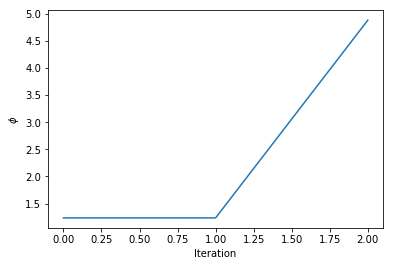

In [26]:
plt.plot(phi_history)
plt.xlabel('Iteration')
plt.ylabel('$\phi$')

0 1.2345


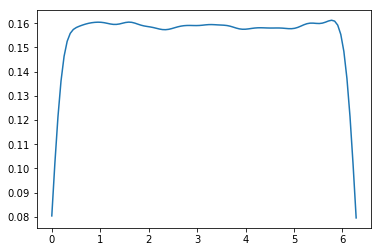

1 1.2345


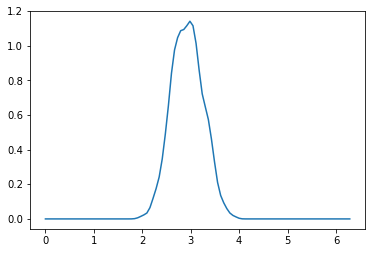

2 4.88034059017


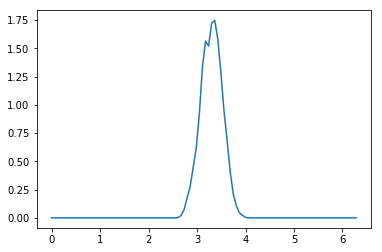

In [27]:
for n,prior in enumerate(prior_history):
    print(n, phi_history[n])
    prior.plot()
    plt.show()

## prototyping approx likelihood

-560.61151599212963

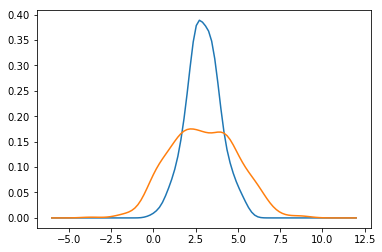

In [47]:
xrange = (3-9,3+3*3)
xtest = np.linspace(xrange[0], xrange[1],100)

simdata = simulator(theta=3,phi=1.5*np.pi,n_samples=500)
approx_density = Distribution(name='approx density', range=xrange,samples=simdata)
density = approx_density.pdf(xtest)
plt.plot(xtest,density)
np.sum(np.log(density))

simdata = simulator(theta=3,phi=0,n_samples=500)
approx_density = Distribution(name='approx density', range=xrange,samples=simdata)
density = approx_density.pdf(xtest)
plt.plot(xtest,density)
np.sum(np.log(density))
